In [ ]:
! pip install brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from brian2 import *
%matplotlib inline
from scipy.signal import find_peaks
from ipywidgets import interact_manual, FloatSlider, interact
#Constants
i_const = 160*pA
C = 100*pF; gL = 12*nS; EL = -60*mV; VT = -50*mV; 
DeltaT = 2*mV; tauw = 130*ms; a = -11*nS;
tau_s = 1*ms; ks= 0.3*nA; ss = 125; ds = 3; hs = -0.045; 
I0 = 1*amp; V0 = 1*volt;
Dn = 0.8; tau_n = 25*Hz; 
epsilon_c = 0.04; tau_c = 10*ms; 
C1 = 0.13; C2 = 0.9; C3 = 0.004; C4 = 2/epsilon_c
tausm = 100*ms; ssm = 100; hsm = 0.45; dsm = 3;
tauGm = 5*tausm; sgm = ssm; hgm = 0.5; dgm = 3;

z0 = 2*ds/(1+2*ds+exp(-2*ss*(-0.015)))
print('z0 = ',z0)
eqs1 = '''
        I = i_const*int(t > 50*ms)*int(t < 2000*ms) : amp
        dv1/dt = (gL*(EL-v1)+gL*DeltaT*exp((v1-VT)/DeltaT) - w1 + I)/C: volt
        dw1/dt=(a*(v1-EL)-w1)/tauw : amp
       '''
eqs2 = '''dv2/dt = (gL*(EL-v2)+gL*DeltaT*exp((v2-VT)/DeltaT) - w2 + I_syn + I_glion)/C : volt
          dw2/dt=(a*(v2-EL)-w2)/tauw : amp
          dz/dt = (1/tau_s)*((1+tanh(ss*((v_inp/V0)-hs)))*(1 - z) - z/ds) : 1
          I_syn = (ks - delta*Gm)*(z-z0) : amp
          I_glion = gamma*Gm : amp
          dGm/dt = (1/tauGm)*((1 + tanh(sgm*(c - hgm)))*(1-Gm)- Gm/dgm) : 1
          dc/dt = (1/tau_c)*(- c - C4*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) + r + alpha*w2 + beta*Sm) : 1 
          dce/dt = (1/(tau_c*epsilon_c))*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) : 1
          dSm/dt = (1/tausm)*((1 + tanh(ssm*(z - hsm)))*(1-Sm)-Sm/dsm) : 1

          v_inp : volt (linked)
      '''

z0 =  0.1211605190692803


In [ ]:
run_time = 10000*ms

In [ ]:
#Définition de la synapse  
def synapse_plot(r,Alpha,beta,Gamma,delta):
    #Initialization
    defaultclock.dt = 0.01*ms
    alpha = Alpha*amp**(-1); 
    gamma = Gamma*nA;
    delta = delta*nA
    #PRE-SYNAPTIC NEURON
    neuron1 = NeuronGroup(1, eqs1, threshold='v1 > -30*mV', reset='v1=-70*mV; w1 += 30*pA', method = "euler")
    V1 = StateMonitor(neuron1, 'v1', record=0)
    W1 = StateMonitor(neuron1, 'w1', record=0)
    I1 = StateMonitor(neuron1, 'I', record=0)
    #initial values
    neuron1.v1 = EL
    neuron1.w1 = 0*nA
    
    #POST-SYNAPTIC NEURON
    post_neuron = NeuronGroup(1, eqs2, threshold='v2 > -30*mV', reset='v2=-70*mV; w2 += 30*pA', method = "euler")
    #initial values
    post_neuron.v_inp = linked_var(neuron1, 'v1')
    post_neuron.v2 = EL
    post_neuron.w2 = 0*nA
    
    post_neuron.z = z0
    post_neuron.c = 0
    post_neuron.ce = 0
    post_neuron.Sm = 0
    post_neuron.Gm = 0

    Z = StateMonitor(post_neuron, 'z', record=0)
    Cal = StateMonitor(post_neuron, 'c', record=0)
    CE = StateMonitor(post_neuron, 'ce', record=0)
    SM = StateMonitor(post_neuron, 'Sm', record=0)
    GM = StateMonitor(post_neuron, 'Gm', record=0)
    V2 = StateMonitor(post_neuron, 'v2', record=0)
    #V21 = StateMonitor(post_neuron, 'v_inp', record=0)
    W2 = StateMonitor(post_neuron, 'w2', record=0)
    I2 = StateMonitor(post_neuron, 'I_syn', record=0)
    IG = StateMonitor(post_neuron, 'I_glion', record=0)

    #Synapse
    syn = Synapses(neuron1, post_neuron)
    syn.connect(i=0, j=0)
    run(run_time)
    '''
    #PLOT
    plot(V1.v1[0], W1.w1[0], label='W1(v1)')
    xlabel('v1')
    ylabel('w1')
    legend();
    plt.savefig(str(i)+'W1(v1).png')
    show()
    plot(V2.v2[0], W2.w2[0], label='W2(v2)')
    xlabel('v2')
    ylabel('w2')
    legend();
    plt.savefig(str(i)+'W2(v2).png')
    show()
    plot(I2.I_syn[0], V1.v1[0], label='V1(Isyn)')
    xlabel('Isyn')
    ylabel('V1')
    legend();
    #plt.savefig(str(i)+'V1(Isyn).png')
    show()
    #Plot
    '''
    plot(V1.t/ms, V1.v1[0], label='Pre-synaptic neuron v1')
    #plot(V21.t/ms, V21.v_inp[0], label='Pre-synaptic neuron v1 from synapse equation')
    plot(V2.t/ms, V2.v2[0], label='Post-synaptic neuron v2')
    xlabel('Time (ms)')
    ylabel('v (V)')
    legend();
    #plt.savefig(str(i)+'V(t).png')
    show()
    '''
    plot(W1.t/ms, W1.w1[0], label='Pre-synaptic neuron w1')
    #plot(V21.t/ms, V21.v_inp[0], label='Pre-synaptic neuron v1 from synapse equation')
    plot(W2.t/ms, W2.w2[0], label='Post-synaptic neuron w2')
    xlabel('Time (ms)')
    ylabel('w (W)')
    legend();
    plt.savefig(str(i)+'W(t).png')
    show()
    '''
    
    plot(Cal.t/ms, Cal.c[0], label='c',color='m')
    plot(CE.t/ms, CE.ce[0], label='ce')
    plot(SM.t/ms, SM.Sm[0], label='Sm')
    plot(GM.t/ms, GM.Gm[0], label='Gm')
    xlabel('Time (ms)')
    ylabel('c (g.L-1)')
    legend();
    #plt.savefig(str(i)+'C(t).png')
    show()
    
    plot(I2.t/ms, I2.I_syn[0], label='I_syn')
    plot(I1.t/ms, I1.I[0], label='I1')
    plot(IG.t/ms, IG.I_glion[0], label='Iglion')
    plot(IG.t/ms, IG.I_glion[0]+I2.I_syn[0], label='Isyn + Iglion')
    xlabel('Time (ms)')
    ylabel('Courants (A)')
    legend(); 
    show()

    #SPIKES
    peaks_V1, _ = find_peaks(V1.v1[0])
    print(peaks_V1)
    peaks_V2, _ = find_peaks(V2.v2[0])
    peaks_c, _ = find_peaks(Cal.c[0])
    ITC = [Cal.t[peaks_c[i]-peaks_c[i-1]] for i in range(1,len(peaks_c))]
    ITV1 = [V1.t[peaks_V1[i]-peaks_V1[i-1]] for i in range(1,len(peaks_V1))]
    ITV2 = [V2.t[peaks_V2[i]-peaks_V2[i-1]] for i in range(1,len(peaks_V2))]
    print('V1 : ', len(peaks_V1),'V2 : ', len(peaks_V2),'c : ', len(peaks_c))
    return ITC,len(peaks_c),ITV1,len(peaks_V1),ITV2,len(peaks_V2)
    

    
    



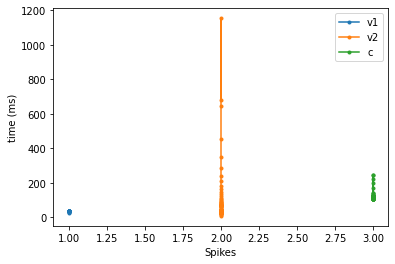

In [ ]:
i_const = 160*pA
#ITC1,lenC1,ITV11,lenV11,ITV21,lenV21 = synapse_plot(0.31,0.001,0.1,0.2,0.5)

plot((lenV11-1)*[1],ITV11/ms, label = 'v1', marker=".")
plot((lenV21-1)*[2],ITV21/ms, label = 'v2', marker=".")
plot((lenC1-1)*[3],ITC1/ms, label = 'c', marker=".")

ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('M1_Spikes.png')
show()

Test I1


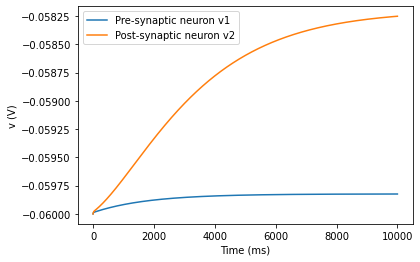

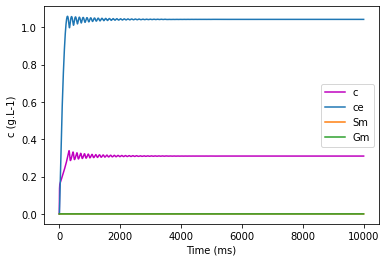

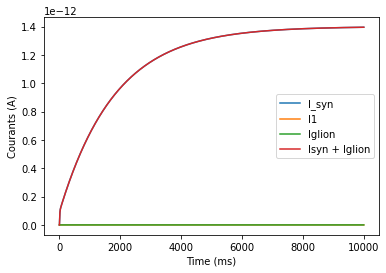

[]
V1 :  0 V2 :  0 c :  80


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



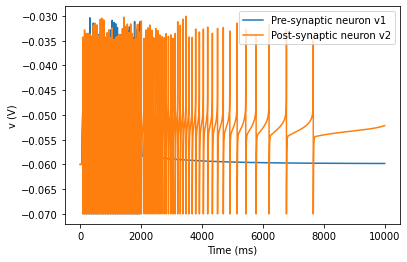

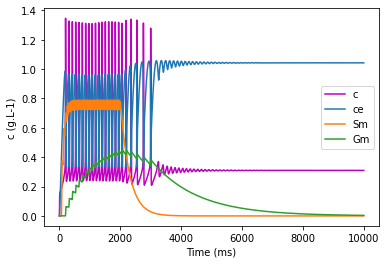

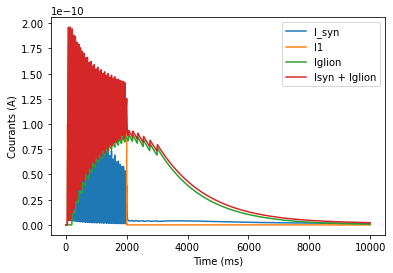

[  9077  14528  20150  25799  31452  37103  42757  48409  54062  59714
  65367  71020  76673  82325  87978  93632  99285 104938 110590 116242
 121894 127546 133199 138852 144505 150158 155812 161465 167117 172770
 178424 184076 189728 195382 200000]
V1 :  35 V2 :  81 c :  78


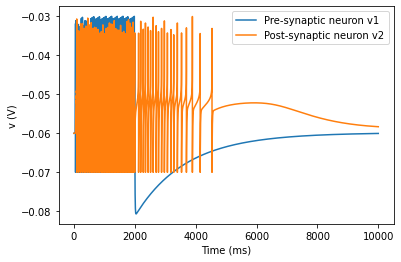

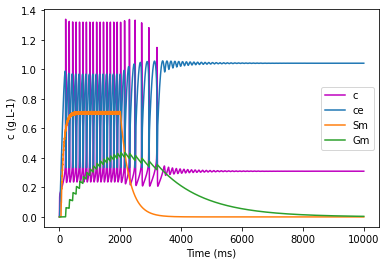

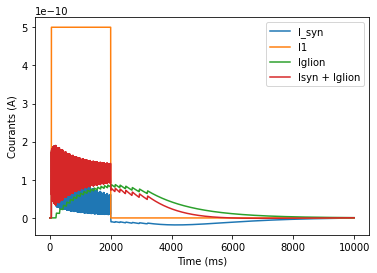

[  5386   5984   6616   7285   7993   8741   9531  10364  11240  12158
  13117  14115  15149  16216  17312  18434  19578  20741  21920  23112
  24315  25526  26744  27968  29196  30427  31661  32897  34135  35375
  36616  37857  39099  40342  41585  42828  44072  45316  46560  47804
  49048  50292  51536  52780  54024  55269  56513  57758  59002  60247
  61491  62736  63980  65225  66469  67713  68958  70202  71447  72691
  73936  75180  76425  77669  78914  80158  81403  82647  83892  85136
  86380  87625  88869  90114  91358  92603  93847  95092  96336  97581
  98825 100070 101314 102559 103803 105048 106292 107536 108781 110025
 111270 112514 113759 115003 116248 117492 118737 119981 121226 122470
 123715 124959 126203 127448 128692 129937 131181 132426 133670 134915
 136159 137404 138648 139893 141137 142382 143626 144870 146115 147359
 148604 149848 151093 152337 153582 154826 156071 157315 158560 159804
 161049 162293 163537 164782 166026 167271 168515 169760 171004 172249
 17349

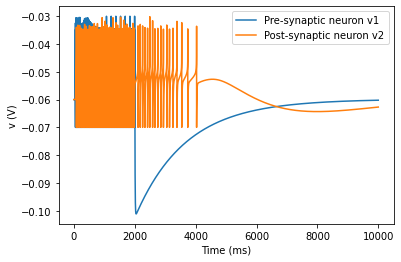

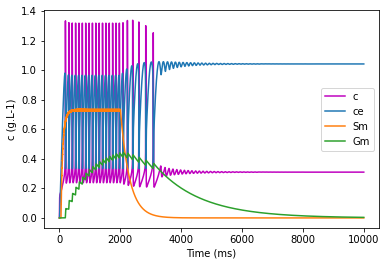

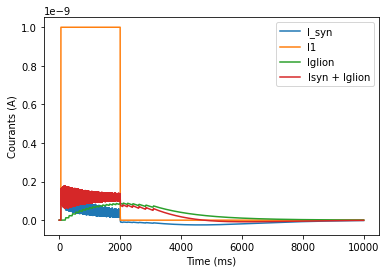

[  5194   5490   5795   6108   6430   6762   7103   7454   7815   8186
   8567   8959   9361   9774  10198  10633  11079  11535  12002  12480
  12968  13466  13974  14492  15019  15555  16099  16651  17211  17778
  18351  18930  19515  20106  20701  21301  21905  22513  23124  23738
  24355  24975  25597  26221  26847  27475  28104  28735  29367  30000
  30634  31269  31905  32541  33178  33816  34454  35093  35732  36371
  37011  37651  38291  38931  39572  40213  40854  41495  42136  42777
  43418  44059  44701  45343  45985  46627  47269  47911  48553  49195
  49837  50479  51121  51763  52405  53047  53689  54331  54973  55615
  56257  56899  57541  58183  58825  59467  60109  60751  61393  62035
  62677  63319  63961  64603  65245  65887  66529  67171  67813  68455
  69097  69739  70381  71023  71665  72307  72949  73591  74233  74875
  75517  76159  76801  77443  78085  78727  79369  80011  80653  81295
  81937  82579  83221  83863  84505  85147  85789  86431  87073  87715
  8835

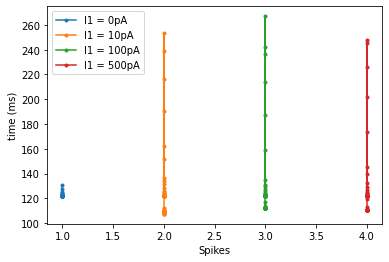

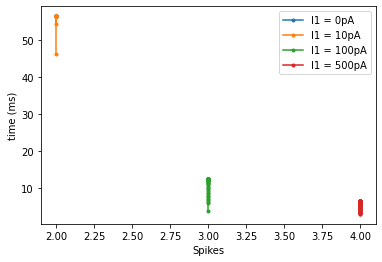

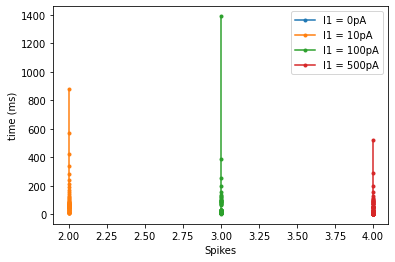

In [ ]:
print('Test I1')
i_const = 0*pA
ITC1,lenC1,ITV11,lenV11,ITV21,lenV21 = synapse_plot(0.31,0.001,0.1,0.2,0.5)
i_const = 100*pA
ITC2,lenC2,ITV12,lenV12,ITV22,lenV22 = synapse_plot(0.31,0.001,0.1,0.2,0.5)
i_const = 500*pA
ITC3,lenC3,ITV13,lenV13,ITV23,lenV23 = synapse_plot(0.31,0.001,0.1,0.2,0.5)
i_const = 1000*pA
ITC4,lenC4,ITV14,lenV14,ITV24,lenV24 = synapse_plot(0.31,0.001,0.1,0.2,0.5)

#C
plot((lenC1-1)*[1],ITC1/ms, label = 'I1 = 0pA', marker=".")
plot((lenC2-1)*[2],ITC2/ms, label = 'I1 = 10pA', marker=".")
plot((lenC3-1)*[3],ITC3/ms, label = 'I1 = 100pA', marker=".")
plot((lenC4-1)*[4],ITC4/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_C_Spikes.png')
show()

#V1
plot((lenV11-1)*[1],ITV11/ms, label = 'I1 = 0pA', marker=".")
plot((lenV12-1)*[2],ITV12/ms, label = 'I1 = 10pA', marker=".")
plot((lenV13-1)*[3],ITV13/ms, label = 'I1 = 100pA', marker=".")
plot((lenV14-1)*[4],ITV14/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V1_Spikes.png')
show()

#V2
plot((lenV21-1)*[1],ITV21/ms, label = 'I1 = 0pA', marker=".")
plot((lenV22-1)*[2],ITV22/ms, label = 'I1 = 10pA', marker=".")
plot((lenV23-1)*[3],ITV23/ms, label = 'I1 = 100pA', marker=".")
plot((lenV24-1)*[4],ITV24/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V2_Spikes.png')
show()

Test beta


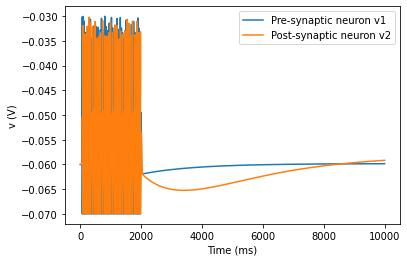

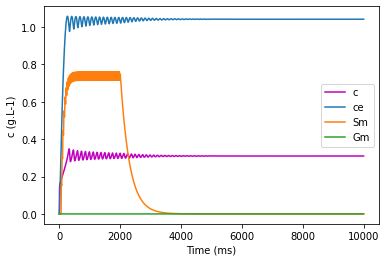

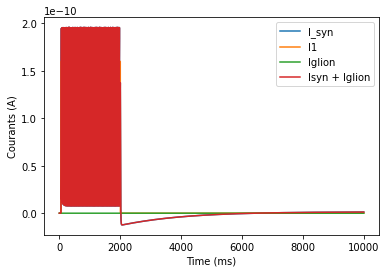

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  57 c :  79


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



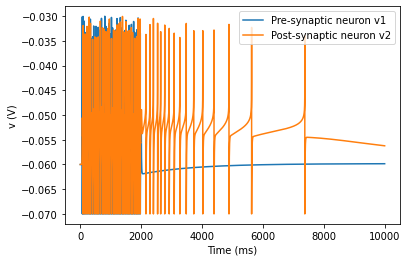

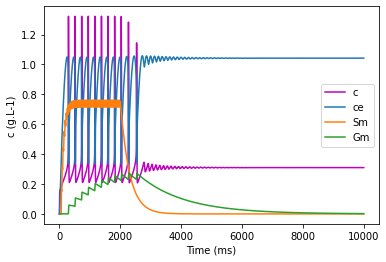

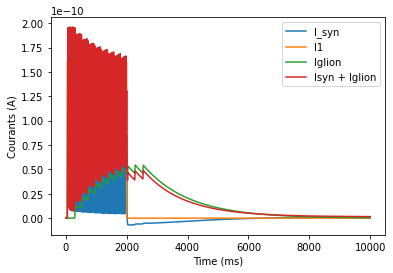

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  77 c :  70


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



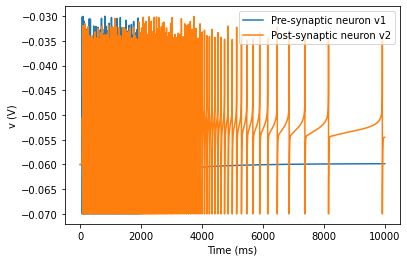

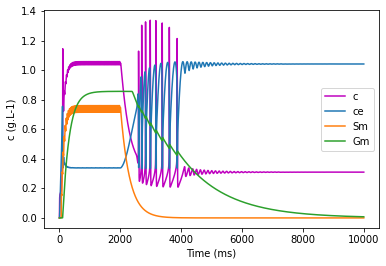

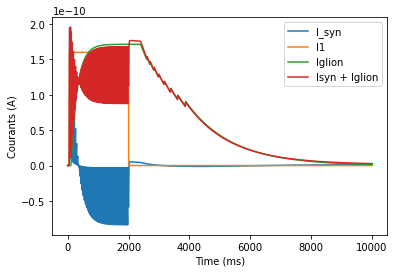

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  136 c :  109


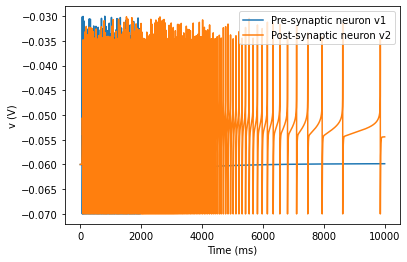

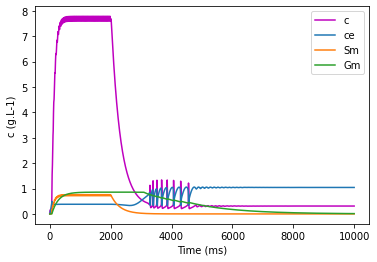

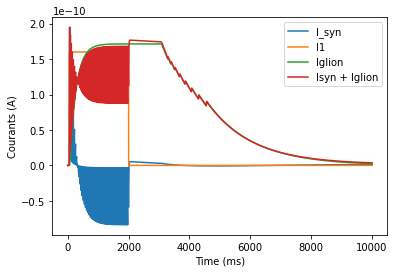

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  156 c :  103


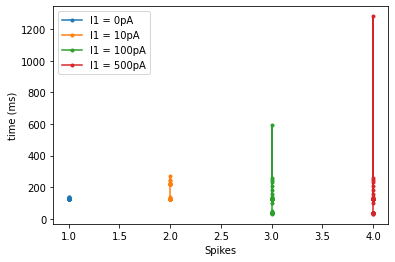

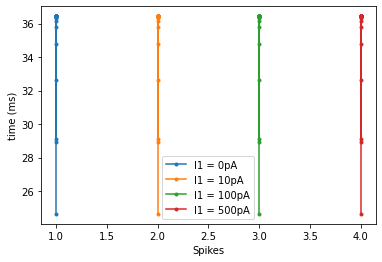

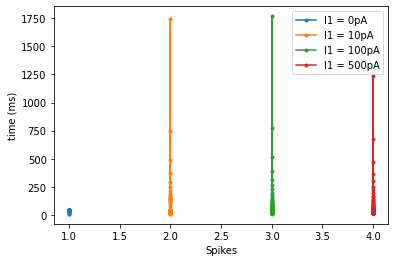

Test gamma


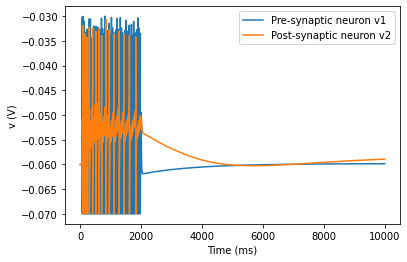

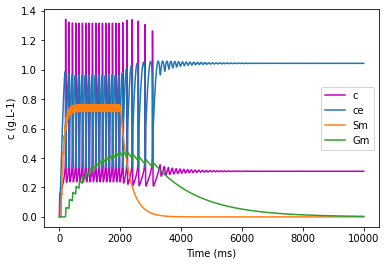

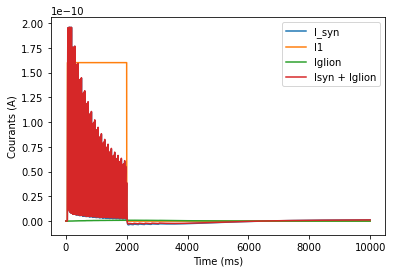

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  56 c :  78


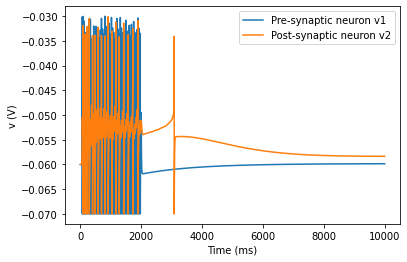

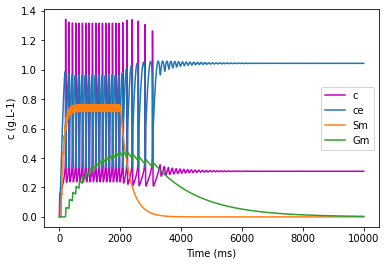

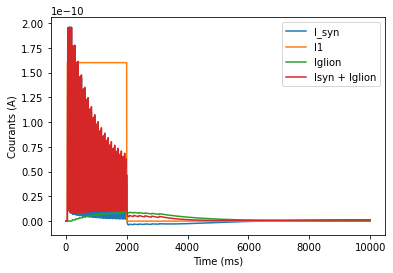

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  58 c :  78


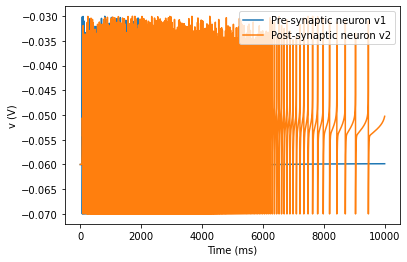

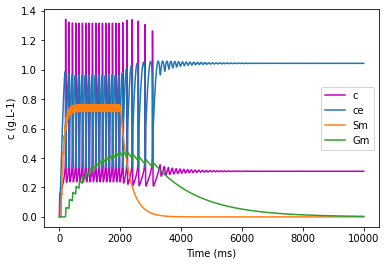

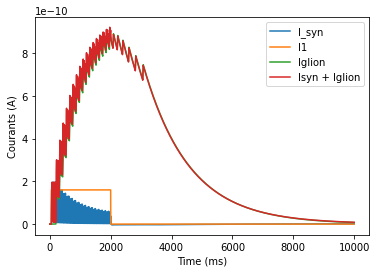

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  502 c :  78


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



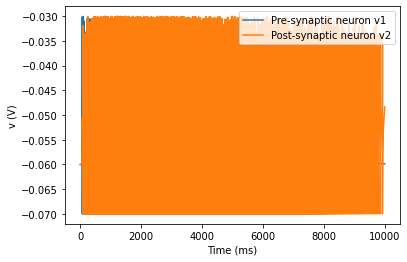

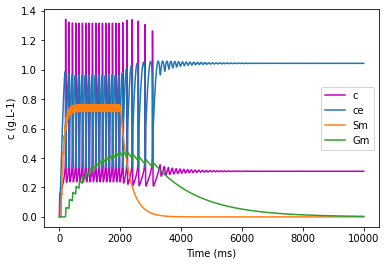

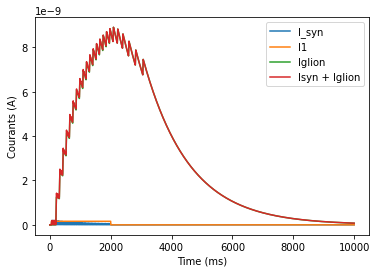

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  4440 c :  78


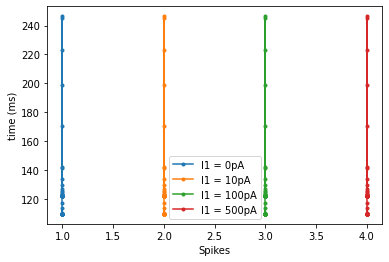

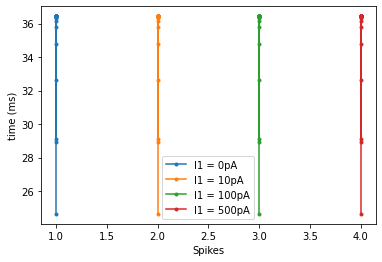

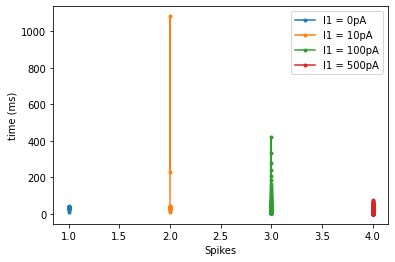

Test r


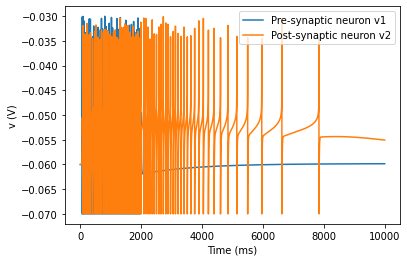

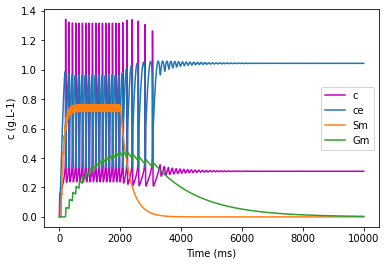

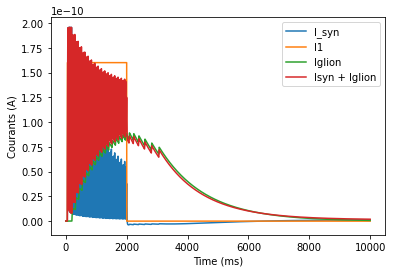

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  88 c :  78


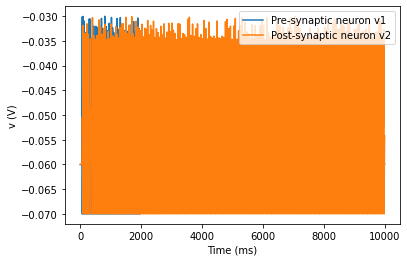

WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



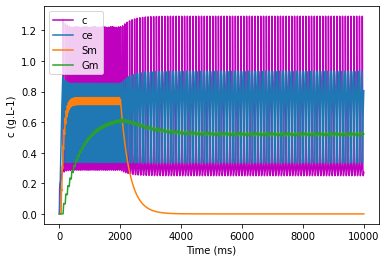

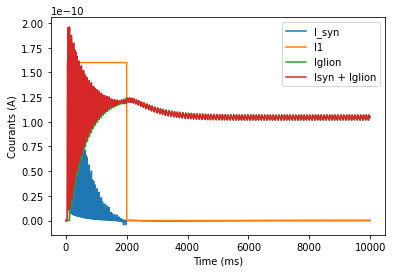

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  197 c :  117


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



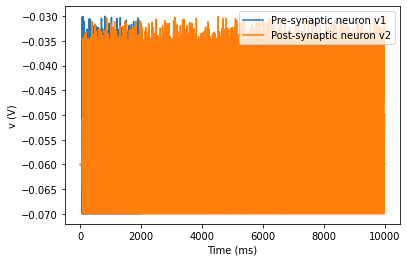

WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



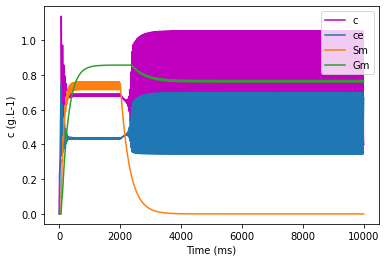

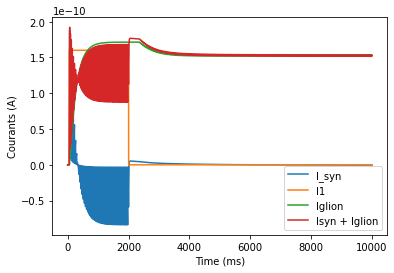

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  282 c :  238


WARNING    /usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



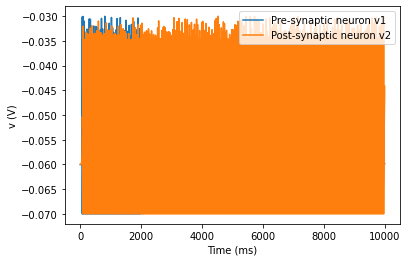

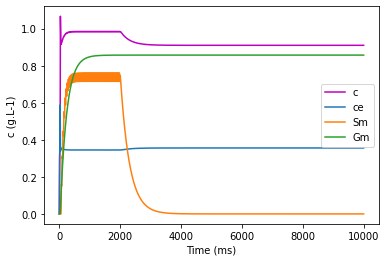

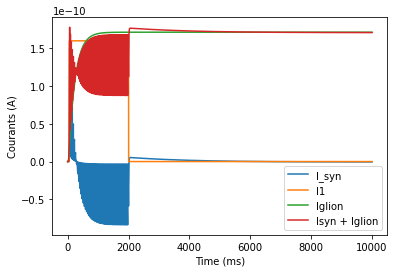

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  306 c :  54


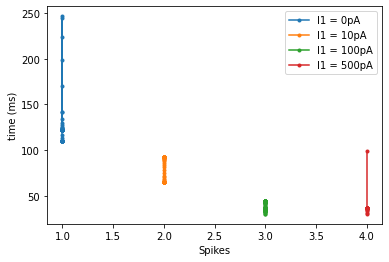

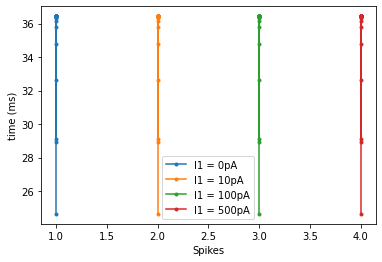

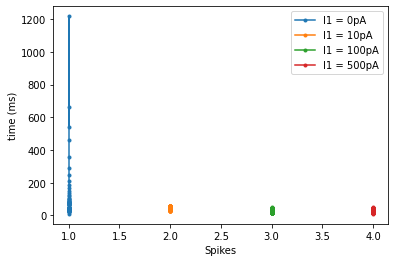

In [ ]:
i_const = 160*pA

print('Test beta')

ITC1,lenC1,ITV11,lenV11,ITV21,lenV21 = synapse_plot(0.31,0.001,0.001,0.2,0.5)
ITC2,lenC2,ITV12,lenV12,ITV22,lenV22 = synapse_plot(0.31,0.001,0.01,0.2,0.5)
ITC3,lenC3,ITV13,lenV13,ITV23,lenV23 = synapse_plot(0.31,0.001,1,0.2,0.5)
ITC4,lenC4,ITV14,lenV14,ITV24,lenV24 = synapse_plot(0.31,0.001,10,0.2,0.5)

#C
plot((lenC1-1)*[1],ITC1/ms, label = 'I1 = 0pA', marker=".")
plot((lenC2-1)*[2],ITC2/ms, label = 'I1 = 10pA', marker=".")
plot((lenC3-1)*[3],ITC3/ms, label = 'I1 = 100pA', marker=".")
plot((lenC4-1)*[4],ITC4/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_C_Spikes.png')
show()

#V1
plot((lenV11-1)*[1],ITV11/ms, label = 'I1 = 0pA', marker=".")
plot((lenV12-1)*[2],ITV12/ms, label = 'I1 = 10pA', marker=".")
plot((lenV13-1)*[3],ITV13/ms, label = 'I1 = 100pA', marker=".")
plot((lenV14-1)*[4],ITV14/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V1_Spikes.png')
show()

#V2
plot((lenV21-1)*[1],ITV21/ms, label = 'I1 = 0pA', marker=".")
plot((lenV22-1)*[2],ITV22/ms, label = 'I1 = 10pA', marker=".")
plot((lenV23-1)*[3],ITV23/ms, label = 'I1 = 100pA', marker=".")
plot((lenV24-1)*[4],ITV24/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V2_Spikes.png')
show()


print('Test gamma')

ITC1,lenC1,ITV11,lenV11,ITV21,lenV21 = synapse_plot(0.31,0.001,0.1,0.002,0.5)
ITC2,lenC2,ITV12,lenV12,ITV22,lenV22 = synapse_plot(0.31,0.001,0.1,0.02,0.5)
ITC3,lenC3,ITV13,lenV13,ITV23,lenV23 = synapse_plot(0.31,0.001,0.1,2,0.5)
ITC4,lenC4,ITV14,lenV14,ITV24,lenV24 = synapse_plot(0.31,0.001,0.1,20,0.5)

#C
plot((lenC1-1)*[1],ITC1/ms, label = 'I1 = 0pA', marker=".")
plot((lenC2-1)*[2],ITC2/ms, label = 'I1 = 10pA', marker=".")
plot((lenC3-1)*[3],ITC3/ms, label = 'I1 = 100pA', marker=".")
plot((lenC4-1)*[4],ITC4/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_C_Spikes.png')
show()

#V1
plot((lenV11-1)*[1],ITV11/ms, label = 'I1 = 0pA', marker=".")
plot((lenV12-1)*[2],ITV12/ms, label = 'I1 = 10pA', marker=".")
plot((lenV13-1)*[3],ITV13/ms, label = 'I1 = 100pA', marker=".")
plot((lenV14-1)*[4],ITV14/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V1_Spikes.png')
show()

#V2
plot((lenV21-1)*[1],ITV21/ms, label = 'I1 = 0pA', marker=".")
plot((lenV22-1)*[2],ITV22/ms, label = 'I1 = 10pA', marker=".")
plot((lenV23-1)*[3],ITV23/ms, label = 'I1 = 100pA', marker=".")
plot((lenV24-1)*[4],ITV24/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V2_Spikes.png')
show()


print('Test r')

ITC1,lenC1,ITV11,lenV11,ITV21,lenV21 = synapse_plot(0.31,0.001,0.1,0.2,0.5)
ITC2,lenC2,ITV12,lenV12,ITV22,lenV22 = synapse_plot(0.41,0.001,0.1,0.2,0.5)
ITC3,lenC3,ITV13,lenV13,ITV23,lenV23 = synapse_plot(0.61,0.001,0.1,0.2,0.5)
ITC4,lenC4,ITV14,lenV14,ITV24,lenV24 = synapse_plot(0.91,0.001,0.1,0.2,0.5)

#C
plot((lenC1-1)*[1],ITC1/ms, label = 'I1 = 0pA', marker=".")
plot((lenC2-1)*[2],ITC2/ms, label = 'I1 = 10pA', marker=".")
plot((lenC3-1)*[3],ITC3/ms, label = 'I1 = 100pA', marker=".")
plot((lenC4-1)*[4],ITC4/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_C_Spikes.png')
show()

#V1
plot((lenV11-1)*[1],ITV11/ms, label = 'I1 = 0pA', marker=".")
plot((lenV12-1)*[2],ITV12/ms, label = 'I1 = 10pA', marker=".")
plot((lenV13-1)*[3],ITV13/ms, label = 'I1 = 100pA', marker=".")
plot((lenV14-1)*[4],ITV14/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V1_Spikes.png')
show()

#V2
plot((lenV21-1)*[1],ITV21/ms, label = 'I1 = 0pA', marker=".")
plot((lenV22-1)*[2],ITV22/ms, label = 'I1 = 10pA', marker=".")
plot((lenV23-1)*[3],ITV23/ms, label = 'I1 = 100pA', marker=".")
plot((lenV24-1)*[4],ITV24/ms, label = 'I1 = 500pA', marker=".")
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
#plt.savefig('I_V2_Spikes.png')
show()


In [ ]:
#synapse_plot(0.31,0.001,0.1,0.2,0.5)

Test delta


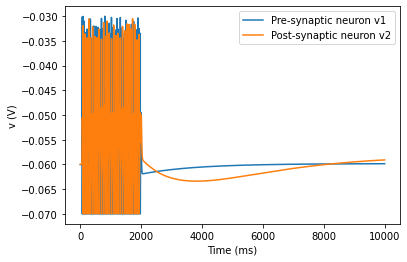

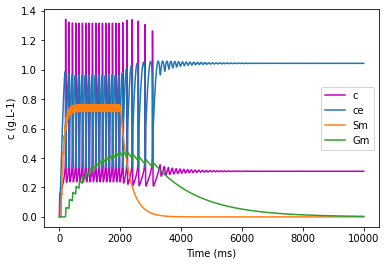

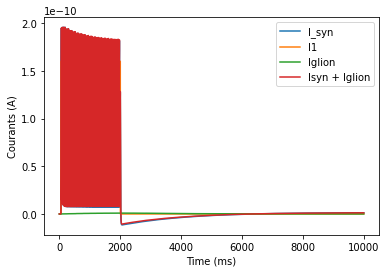

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  55 c :  78


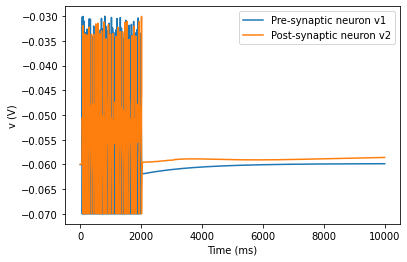

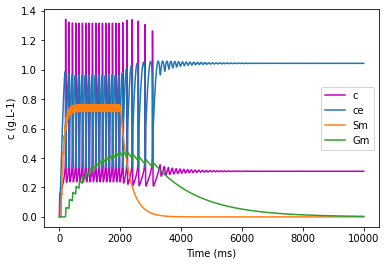

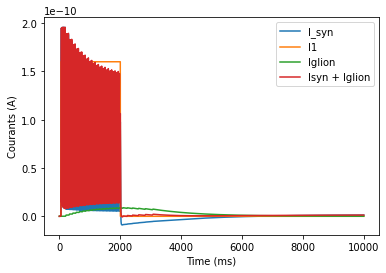

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  61 c :  78


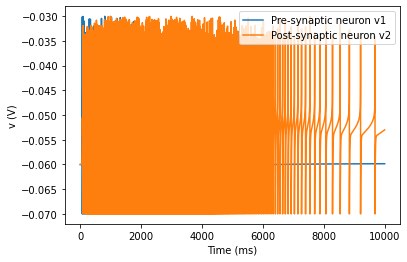

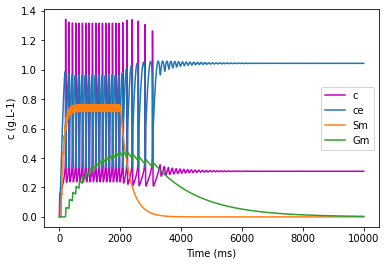

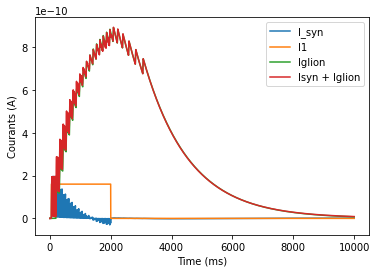

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  497 c :  78


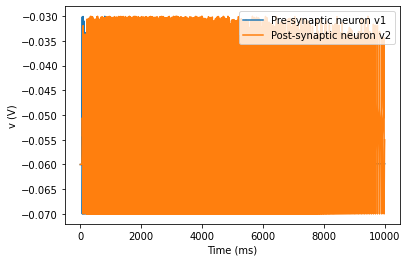

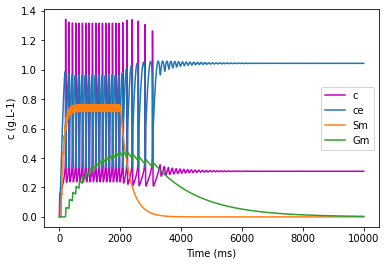

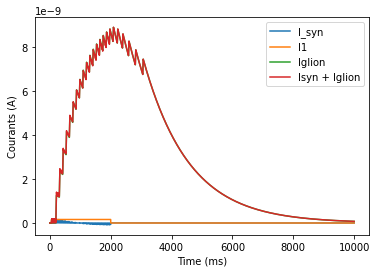

[  6567   9031  11941  15207  18685  22263  25881  29516  33156  36797
  40440  44084  47727  51371  55014  58658  62301  65945  69589  73232
  76875  80519  84162  87805  91448  95092  98735 102379 106022 109665
 113308 116952 120596 124239 127882 131526 135169 138812 142455 146099
 149743 153386 157029 160673 164316 167960 171603 175247 178890 182533
 186177 189821 193464 197107 200000]
V1 :  55 V2 :  4431 c :  78


([113.41 * msecond,
  110.43 * msecond,
  109.74 * msecond,
  109.59 * msecond,
  109.55 * msecond,
  109.56 * msecond,
  109.56 * msecond,
  109.58 * msecond,
  109.59 * msecond,
  109.61 * msecond,
  109.63 * msecond,
  109.64 * msecond,
  109.67 * msecond,
  109.69 * msecond,
  109.72 * msecond,
  109.75 * msecond,
  116.88 * msecond,
  141.7 * msecond,
  170.29 * msecond,
  198.56 * msecond,
  223.4 * msecond,
  245.05 * msecond,
  246.44 * msecond,
  141.38 * msecond,
  133.63 * msecond,
  129.56 * msecond,
  127.1 * msecond,
  125.5 * msecond,
  124.42 * msecond,
  123.66 * msecond,
  123.13 * msecond,
  122.74 * msecond,
  122.47 * msecond,
  122.26 * msecond,
  122.12 * msecond,
  122.02 * msecond,
  121.94 * msecond,
  121.89 * msecond,
  121.84 * msecond,
  121.82 * msecond,
  121.8 * msecond,
  121.79 * msecond,
  121.79 * msecond,
  121.77 * msecond,
  121.78 * msecond,
  121.78 * msecond,
  121.78 * msecond,
  121.78 * msecond,
  121.78 * msecond,
  121.78 * msecond,
  121

In [ ]:
print('Test delta')
synapse_plot(0.31,0.001,0.1,0.002,0.05)
synapse_plot(0.31,0.001,0.1,0.02,0.2)
synapse_plot(0.31,0.001,0.1,2,0.8)
synapse_plot(0.31,0.001,0.1,20,1)
